In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import nltk
import string
from nltk.corpus import stopwords

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [3]:
with open('/content/drive/MyDrive/News_Category_Dataset_v3.json','r') as f:
    jdata = f.read()

jdata2 = [json.loads(line) for line in jdata.split('\n') if line]
df = pd.DataFrame.from_records(jdata2)

In [5]:
# Check for empty strings or empty lists/objects in each column
def check_empty_values(series):
    return (series.apply(lambda x: x == '' or x == [] or x == {})).sum()

empty_values_per_column = df.apply(check_empty_values)

empty_values_per_column

link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64

In [6]:
import pandas as pd

# Load your dataframe here
# df = pd.read_csv('path_to_your_csv.csv')

# Replace empty descriptions with the headline
df['short_description'] = df.apply(
    lambda row: row['headline'] if pd.isnull(row['short_description']) or row['short_description'] == '' else row['short_description'],
    axis=1
)


In [7]:
# Check for empty strings or empty lists/objects in each column
def check_empty_values(series):
    return (series.apply(lambda x: x == '' or x == [] or x == {})).sum()

empty_values_per_column = df.apply(check_empty_values)

empty_values_per_column

link                     0
headline                 6
category                 0
short_description        5
authors              37418
date                     0
dtype: int64

In [8]:
import pandas as pd

# Load your dataframe here
# df = pd.read_csv('path_to_your_csv.csv')

# Replace empty strings with NaN
df['short_description'].replace('', pd.NA, inplace=True)

# Drop rows where 'short_description' is NaN
df.dropna(subset=['short_description'], inplace=True)

# Now df no longer contains rows with empty 'short_description' entries.

In [9]:
# Check for empty strings or empty lists/objects in each column
def check_empty_values(series):
    return (series.apply(lambda x: x == '' or x == [] or x == {})).sum()

empty_values_per_column = df.apply(check_empty_values)

empty_values_per_column

link                     0
headline                 1
category                 0
short_description        0
authors              37418
date                     0
dtype: int64

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import json

In [11]:
# Find the top 10 categories
top_categories = df['category'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 8 categories
df_filtered = df[df['category'].isin(top_categories)]

# Drop all other columns except 'category' and 'short_description'
df_final = df_filtered[['category', 'short_description']]

# You can now work with df_final which contains only the data you want

In [12]:
import pandas as pd

# Assuming df_final is your dataframe and it has been loaded correctly.

# Shuffle the dataframe
df_final = df_final.sample(frac=1).reset_index(drop=True)

# Filter out the 'POLITICS' category
politics_df = df_final[df_final['category'] == 'POLITICS']
other_categories_df = df_final[df_final['category'] != 'POLITICS']

# Sample 12,000 entries from the 'POLITICS' category
politics_sampled_df = politics_df.sample(n=17500)

# Concatenate the sampled 'POLITICS' with the rest of the categories
df_final = pd.concat([politics_sampled_df, other_categories_df]).sample(frac=1).reset_index(drop=True)

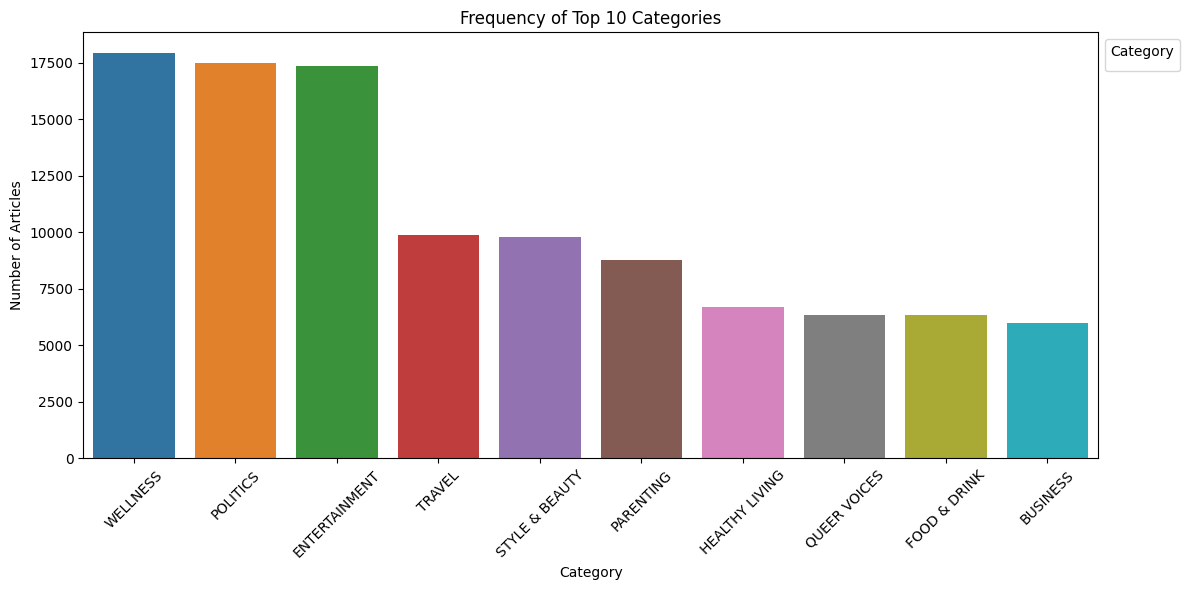

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# final DataFrame after filtering with the top 8 categories

# Count the number of occurrences for each category
category_counts = df_final['category'].value_counts().sort_values(ascending=False)

# Set the figure size for better visibility
plt.figure(figsize=(12, 6))

# Create a bar plot with 'category' on the x-axis and the counts on the y-axis
sns.barplot(x=category_counts.index, y=category_counts.values)

# Set the title and labels of the plot
plt.title('Frequency of Top 10 Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Move the legend to the side
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))

# Ensure the layout fits well
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
# Upsampling the data
SEED = 42
df_list = []
#Get news in top 15 categories
for i in top_categories:
    df_list.append(pd.DataFrame(df_final[df_final["category"]==i]))
for i in range(len(df_list)):
    df_list[i] = pd.DataFrame(df_list[i][df_list[i]["short_description"]!=""])
for i in range(len(df_list)):
    df_list[i] = df_list[i].sample(df_list[0].shape[0], replace=True, random_state=SEED)
df_upsample = pd.concat(df_list)
print(df_upsample.shape)

(175000, 2)


In [15]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you have these NLTK datasets downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Defining the stemmer
stemmer = SnowballStemmer("english")

# Updated stopwords list
stop_words = set(stopwords.words('english') + ['u', 'im', 'c'])

# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Function to remove stopwords
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

# Function to stem text
def stemm_text(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

# Function to preprocess data
def preprocess_data(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    return text



# Split the dataset into train, validation, and test sets
train, test = train_test_split(df_upsample, test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=0.25, random_state=42)  # 60% train, 20% validation, 20% test


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [24]:
# Apply preprocessing to the 'short_description' column
train['clean_text'] = train['short_description'].apply(preprocess_data)
validation['clean_text'] = validation['short_description'].apply(preprocess_data)
test['clean_text'] = test['short_description'].apply(preprocess_data)


In [25]:
# Function to transform data using TF-IDF
def transform_data_tfidf(train_data, validation_data, test_data, text_column, target_column):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 2))

    # Fit and transform the training data
    X_train_transformed = tfidf_vectorizer.fit_transform(train_data[text_column])
    y_train = train_data[target_column]

    # Transform the validation data
    X_validation_transformed = tfidf_vectorizer.transform(validation_data[text_column])
    y_validation = validation_data[target_column]

    # Transform the test data
    X_test_transformed = tfidf_vectorizer.transform(test_data[text_column])
    y_test = test_data[target_column]

    return X_train_transformed, y_train, X_validation_transformed, y_validation, X_test_transformed, y_test

# Applying the transformation to your dataset
X_train_tfidf, y_train, X_validation_tfidf, y_validation, X_test_tfidf, y_test = transform_data_tfidf(train, validation, test, 'clean_text', 'category')


### BAYESIAN OPTIMIZATION

In [ ]:
!pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.6 MB/s eta 0:00:00


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: OrderedDict([('C', 9.971154848447195), ('penalty', 'l1'), ('solver', 'liblinear')])
Accuracy:

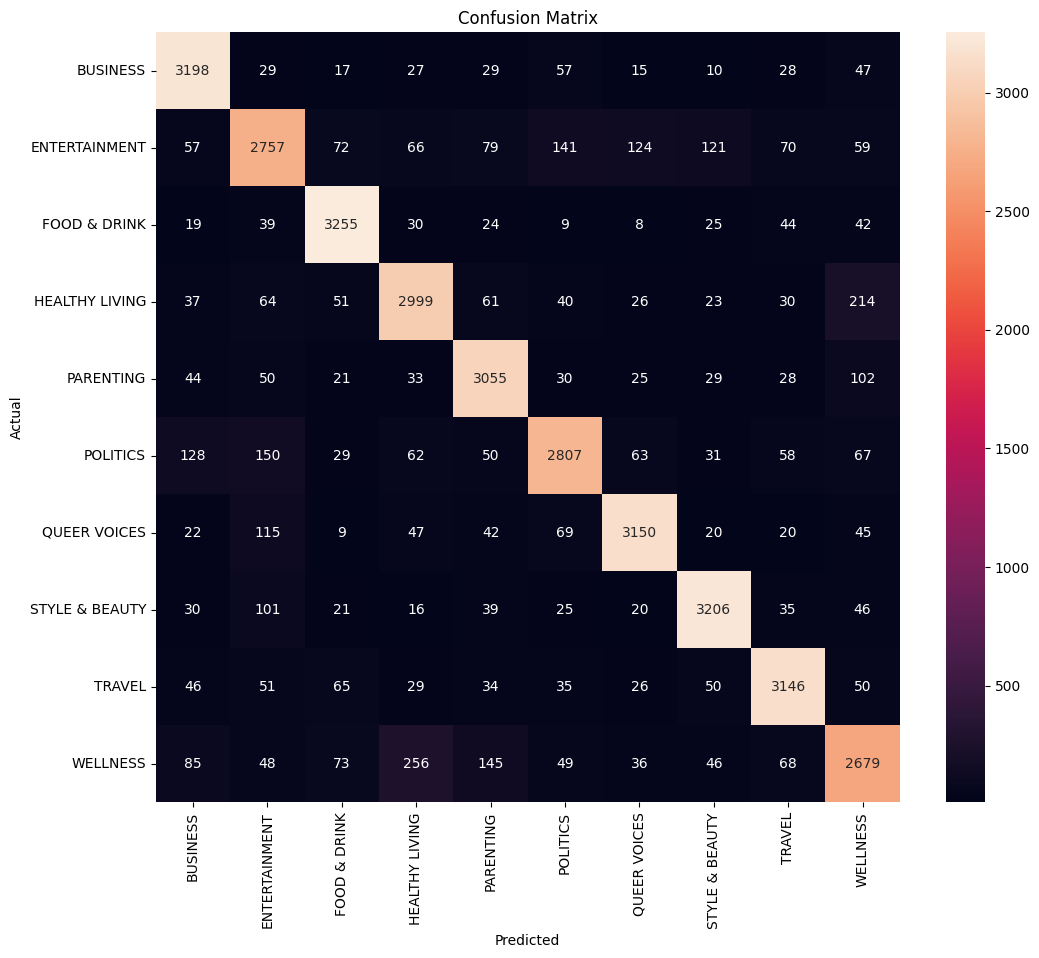

In [29]:
import pandas as pd
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

# Assuming you have a DataFrame 'df' with 'text' as the feature and 'label' as the target column
# Adjust the column names accordingly based on your dataset



# Define your logistic regression model
logreg_model = LogisticRegression()

# Define the hyperparameter search space
param_space = {
    'C': (0.1, 10.0, 'log-uniform'),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(
    logreg_model,
    param_space,
    n_iter=15,
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
# Fit the model to the training and validation data
X_train_validation_tfidf = scipy.sparse.vstack((X_train_tfidf, X_validation_tfidf))
y_train_validation = pd.concat([y_train, y_validation])
bayes_search.fit(X_train_validation_tfidf, y_train_validation)

# Get the best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)


# Train the logistic regression model with the best hyperparameters on the full training set
best_logistic_model = LogisticRegression(**best_params, random_state=42)
best_logistic_model.fit(X_train_tfidf, y_train)

# Evaluate the best model on the test set
y_pred = best_logistic_model.predict(X_test_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print the classification report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Best Hyperparameters for Random Forest:
OrderedDict([('max_depth', 20), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 1000)])
Accuracy for Random Forest: 0.6321142857142857
Classification Report for Random Forest:
                precision    recall  f1-score   support

      BUSINESS       0.84      0.55      0.67      3457
 ENTERTAINMENT       0.64      0.50      0.56      3546
  FOOD & DRINK       0.47      0.90      0.61      3495
HEALTHY LIVING       0.83      0.35      0.49      3545
     PARENTING       0.57      0.80      0.66      3417
      POLITICS       0.48      0.82      0.60      3445
  QUEER VOICES       0.90      0.52      0.65      3539
STYLE & BEAUTY       0.80      0.69      0.74      3539
        TRAVEL       0.86      0.59      0.70      3532
      WELLNESS       0.61      0.63      0.62      3485

      accuracy                           0.63     35000
     macro avg       0.70      0.63      0.63     35000
  weigh

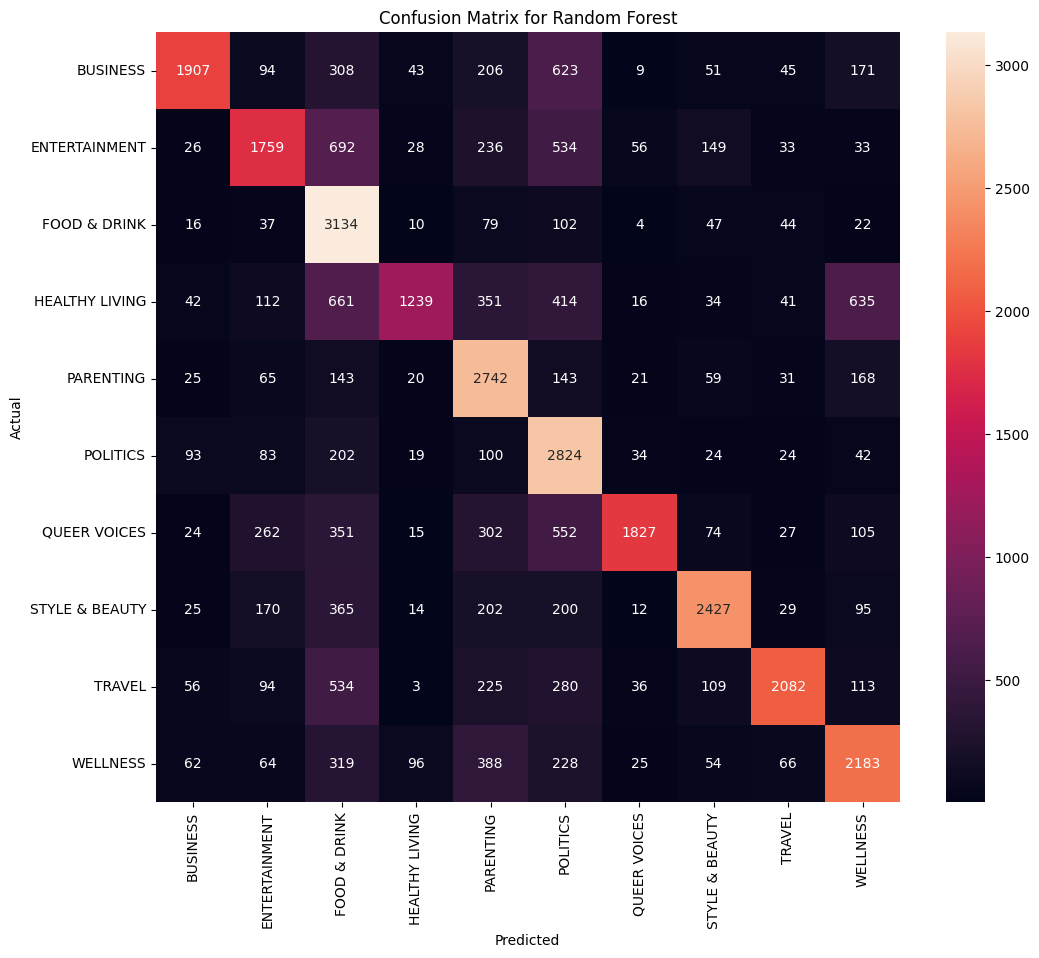

In [30]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the hyperparameters you want to tune and their search spaces
param_dist = {
    'n_estimators': (100, 1000),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create a BayesSearchCV object
bayes_search_rf = BayesSearchCV(
    rf_model,
    search_spaces=param_dist,
    n_iter=15,  # Number of parameter settings that are sampled
    cv=3,
    n_jobs=-1
)

# Fit the model to the training and validation data
X_train_validation_tfidf = scipy.sparse.vstack((X_train_tfidf, X_validation_tfidf))
y_train_validation = pd.concat([y_train, y_validation])
bayes_search_rf.fit(X_train_validation_tfidf, y_train_validation)

# Get the best hyperparameters
best_params_rf = bayes_search_rf.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for Random Forest:")
print(best_params_rf)

# Train the Random Forest model with the best hyperparameters on the full training set
best_rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf_model.fit(X_train_tfidf, y_train)

# Evaluate the best model on the test set
y_pred_rf = best_rf_model.predict(X_test_tfidf)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy for Random Forest: {accuracy_rf}")

# Print the classification report
class_report_rf = classification_report(y_test, y_pred_rf)
print(f"Classification Report for Random Forest:\n{class_report_rf}")

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [31]:
!pip install scikit-optimize


In [ ]:
from sklearn.svm import SVC
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the hyperparameters you want to tune and their search spaces
param_dist = {
    'C': (0.001, 100.0, 'log-uniform'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': (1, 10),
    'gamma': (0.0001, 1.0, 'log-uniform')
}

# Initialize the SVC model
svc_model = SVC(random_state=42)

# Create a BayesSearchCV object
bayes_search_svc = BayesSearchCV(
    svc_model,
    search_spaces=param_dist,
    n_iter=15,  # Number of parameter settings that are sampled
    cv=3,
    n_jobs=-1
)

# Fit the model to the training and validation data
X_train_validation_tfidf = scipy.sparse.vstack((X_train_tfidf, X_validation_tfidf))
y_train_validation = pd.concat([y_train, y_validation])
bayes_search_svc.fit(X_train_validation_tfidf, y_train_validation)

# Get the best hyperparameters
best_params_svc = bayes_search_svc.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for SVC:")
print(best_params_svc)

# Train the SVC model with the best hyperparameters on the full training set
best_svc_model = SVC(**best_params_svc, random_state=42)
best_svc_model.fit(X_train_tfidf, y_train)

# Evaluate the best model on the test set
y_pred_svc = best_svc_model.predict(X_test_tfidf)

# Calculate the accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy for SVC: {accuracy_svc}")

# Print the classification report
class_report_svc = classification_report(y_test, y_pred_svc)
print(f"Classification Report for SVC:\n{class_report_svc}")

# Calculate the confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc, labels=np.unique(y_test))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_svc, annot=True, fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVC')
plt.show()


In [ ]:
import joblib

# After training the logistic regression model:
joblib.dump(best_svc_model, 'SVC_tuned_bayesian.joblib')